In [2]:
import pathlib
import torch
import numpy as np
import matplotlib.pyplot as plt

## Check data

In [3]:
data_location = pathlib.Path.cwd().parent / 'data'
model_location = pathlib.Path.cwd()
output_location = pathlib.Path.cwd()

# Load training data
training_images = torch.from_numpy(np.load(data_location / "train_xs.npz")["train_xs"])
training_metadata = np.load(data_location / "train_ys.npz")
training_labels = torch.from_numpy(training_metadata["train_ys"])
training_snow_labels = torch.from_numpy(training_metadata["train_is_snow"])
training_cloud_labels = torch.from_numpy(training_metadata["train_is_cloud"])
training_dataset = torch.utils.data.TensorDataset(training_images, training_snow_labels, training_cloud_labels, training_labels)

# Load validation data
validation_images = torch.from_numpy(np.load(data_location / "val_xs.npz")["val_xs"])
validation_metadata = np.load(data_location / "val_ys.npz")
validation_labels = torch.from_numpy(validation_metadata["val_ys"])
validation_snow_labels = torch.from_numpy(validation_metadata["val_is_snow"])
validation_cloud_labels = torch.from_numpy(validation_metadata["val_is_cloud"])
validation_dataset = torch.utils.data.TensorDataset(validation_images, validation_snow_labels, validation_cloud_labels, validation_labels)

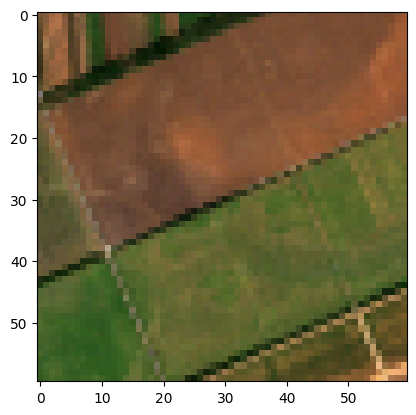

In [4]:
plt.imshow(training_images[1].numpy().transpose(1, 2, 0))

## Evaluate model

In [5]:
import sys
sys.path.append('/Users/luis/Desktop/ETH/Courses/AS24-PAI/task2_handout_e14a688d')

# from importlib import reload

from model import SWAGInference
from util import draw_reliability_diagram, cost_function, setup_seeds, calc_calibration_curve

In [6]:
def evaluate(swag_inference: SWAGInference, eval_dataset: torch.utils.data.Dataset, extended_evaluation: bool, output_location: pathlib.Path) -> None:
    """
    Evaluate your model.
    Feel free to change or extend this code.
    :param swag_inference: Trained model to evaluate
    :param eval_dataset: Validation dataset
    :param: extended_evaluation: If True, generates additional plots
    :param output_location: Directory into which extended evaluation plots are saved
    """

    print("Evaluating model on validation data")

    # We ignore is_snow and is_cloud here, but feel free to use them as well
    images, snow_labels, cloud_labels, labels = eval_dataset.tensors

    # Predict class probabilities on test data,
    # most likely classes (according to the max predicted probability),
    # and classes as predicted by your SWAG implementation.
    all_pred_probabilities = swag_inference.predict_probabilities(images)
    max_pred_probabilities, argmax_pred_labels = torch.max(all_pred_probabilities, dim=-1)
    predicted_labels = swag_inference.predict_labels(all_pred_probabilities)

    # Create a mask that ignores ambiguous samples (those with class -1)
    non_ambiguous_mask = labels != -1

    # Calculate three kinds of accuracy:
    # 1. Overall accuracy, counting "don't know" (-1) as its own class
    # 2. Accuracy on all samples that have a known label. Predicting -1 on those counts as wrong here.
    # 3. Accuracy on all samples that have a known label w.r.t. the class with the highest predicted probability.
    overall_accuracy = torch.mean((predicted_labels == labels).float()).item()
    non_ambiguous_accuracy = torch.mean((predicted_labels[non_ambiguous_mask] == labels[non_ambiguous_mask]).float()).item()
    non_ambiguous_argmax_accuracy = torch.mean(
        (argmax_pred_labels[non_ambiguous_mask] == labels[non_ambiguous_mask]).float()
    ).item()
    print(f"Accuracy (raw): {overall_accuracy:.4f}")
    print(f"Accuracy (non-ambiguous only, your predictions): {non_ambiguous_accuracy:.4f}")
    print(f"Accuracy (non-ambiguous only, predicting most-likely class): {non_ambiguous_argmax_accuracy:.4f}")

    # Determine which threshold would yield the smallest cost on the validation data
    # Note that this threshold does not necessarily generalize to the test set!
    # However, it can help you judge your method's calibration.
    threshold_values = [0.0] + list(torch.unique(max_pred_probabilities, sorted=True))
    costs = []
    for threshold in threshold_values:
        thresholded_predictions = torch.where(max_pred_probabilities <= threshold, -1 * torch.ones_like(predicted_labels), predicted_labels)
        costs.append(cost_function(thresholded_predictions, labels).item())
    best_threshold_index = np.argmin(costs)
    print(f"Best cost {costs[best_threshold_index]} at threshold {threshold_values[best_threshold_index]}")
    print("Note that this threshold does not necessarily generalize to the test set!")

    # Calculate ECE and plot the calibration curve
    calibration_data = calc_calibration_curve(all_pred_probabilities.cpu().numpy(), labels.cpu().numpy(), num_bins=20)
    print("Validation ECE:", calibration_data["ece"])

    if extended_evaluation:
        print("Plotting reliability diagram")
        fig = draw_reliability_diagram(calibration_data)
        fig.savefig(output_location / "reliability_diagram.pdf")

        sorted_confidence_indices = torch.argsort(max_pred_probabilities)

        # Plot samples your model is most confident about
        print("Plotting most confident validation set predictions")
        most_confident_indices = sorted_confidence_indices[-10:]
        fig, ax = plt.subplots(4, 5, figsize=(13, 11))
        for row in range(0, 4, 2):
            for col in range(5):
                sample_index = most_confident_indices[5 * row // 2 + col]
                ax[row, col].imshow(images[sample_index].permute(1, 2, 0).cpu().numpy())
                ax[row, col].set_axis_off()
                ax[row + 1, col].set_title(f"pred. {predicted_labels[sample_index]}, true {labels[sample_index]}")
                bar_colors = ["C0"] * 6
                if labels[sample_index] >= 0:
                    bar_colors[labels[sample_index]] = "C1"
                ax[row + 1, col].bar(
                    np.arange(6), all_pred_probabilities[sample_index].cpu().numpy(), tick_label=np.arange(6), color=bar_colors
                )
        fig.suptitle("Most confident predictions", size=20)
        fig.savefig(output_location / "examples_most_confident.pdf")

        # Plot samples your model is least confident about
        print("Plotting least confident validation set predictions")
        least_confident_indices = sorted_confidence_indices[:10]
        fig, ax = plt.subplots(4, 5, figsize=(13, 11))
        for row in range(0, 4, 2):
            for col in range(5):
                sample_index = least_confident_indices[5 * row // 2 + col]
                ax[row, col].imshow(images[sample_index].permute(1, 2, 0).cpu().numpy())
                ax[row, col].set_axis_off()
                ax[row + 1, col].set_title(f"pred. {predicted_labels[sample_index]}, true {labels[sample_index]}")
                bar_colors = ["C0"] * 6
                if labels[sample_index] >= 0:
                    bar_colors[labels[sample_index]] = "C1"
                ax[row + 1, col].bar(
                    np.arange(6), all_pred_probabilities[sample_index].cpu().numpy(), tick_label=np.arange(6), color=bar_colors
                )
        fig.suptitle("Least confident predictions", size=20)
        fig.savefig(output_location / "examples_least_confident.pdf")

/Users/luis/Desktop/ETH/Courses/AS24-PAI/task2_handout_e14a688d/src/model.py:348: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.network.load_state_dict(torch.load(PRETR

Loaded pretrained MAP weights from /Users/luis/Desktop/ETH/Courses/AS24-PAI/task2_handout_e14a688d/src/map_weights.pt


Running gradient descent for SWA: 100%|██████████| 30/30 [00:53<00:00,  1.77s/it, lr=0.045, avg. epoch loss=0.305, avg. epoch accuracy=0.889]


Evaluating model on validation data


Performing Bayesian model averaging: 100%|██████████| 30/30 [00:25<00:00,  1.16it/s]


Accuracy (raw): 0.5643
Accuracy (non-ambiguous only, your predictions): 0.5333
Accuracy (non-ambiguous only, predicting most-likely class): 0.8833
Best cost 0.6142857074737549 at threshold 0.6772071123123169
Note that this threshold does not necessarily generalize to the test set!
Validation ECE: 0.12113004156521388
Plotting reliability diagram
Plotting most confident validation set predictions
Plotting least confident validation set predictions


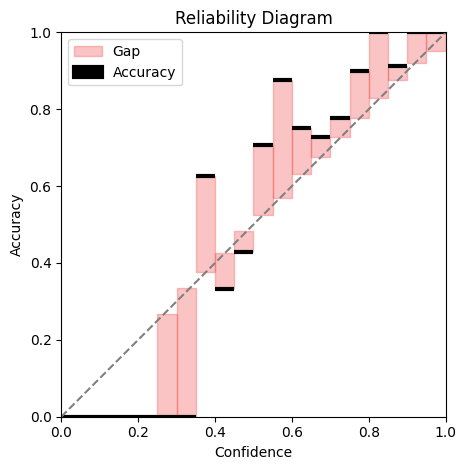

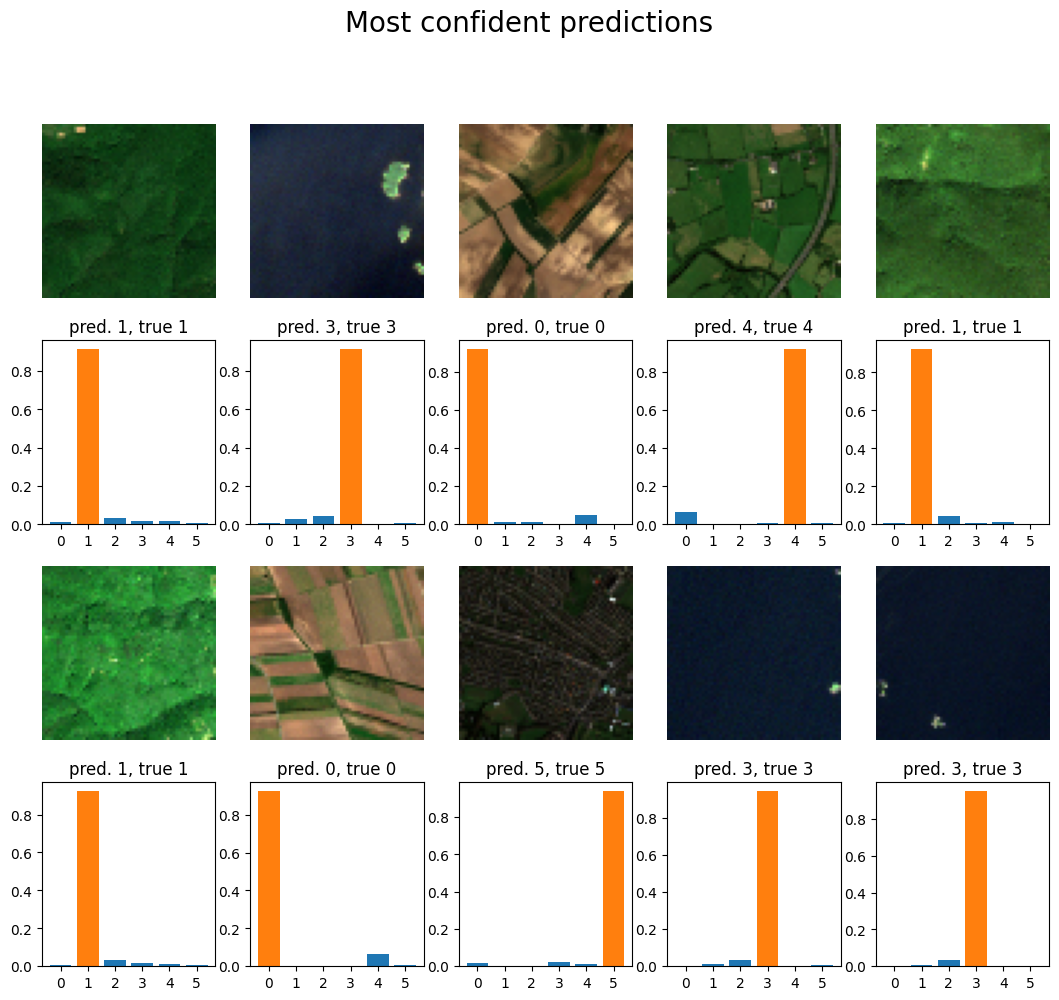

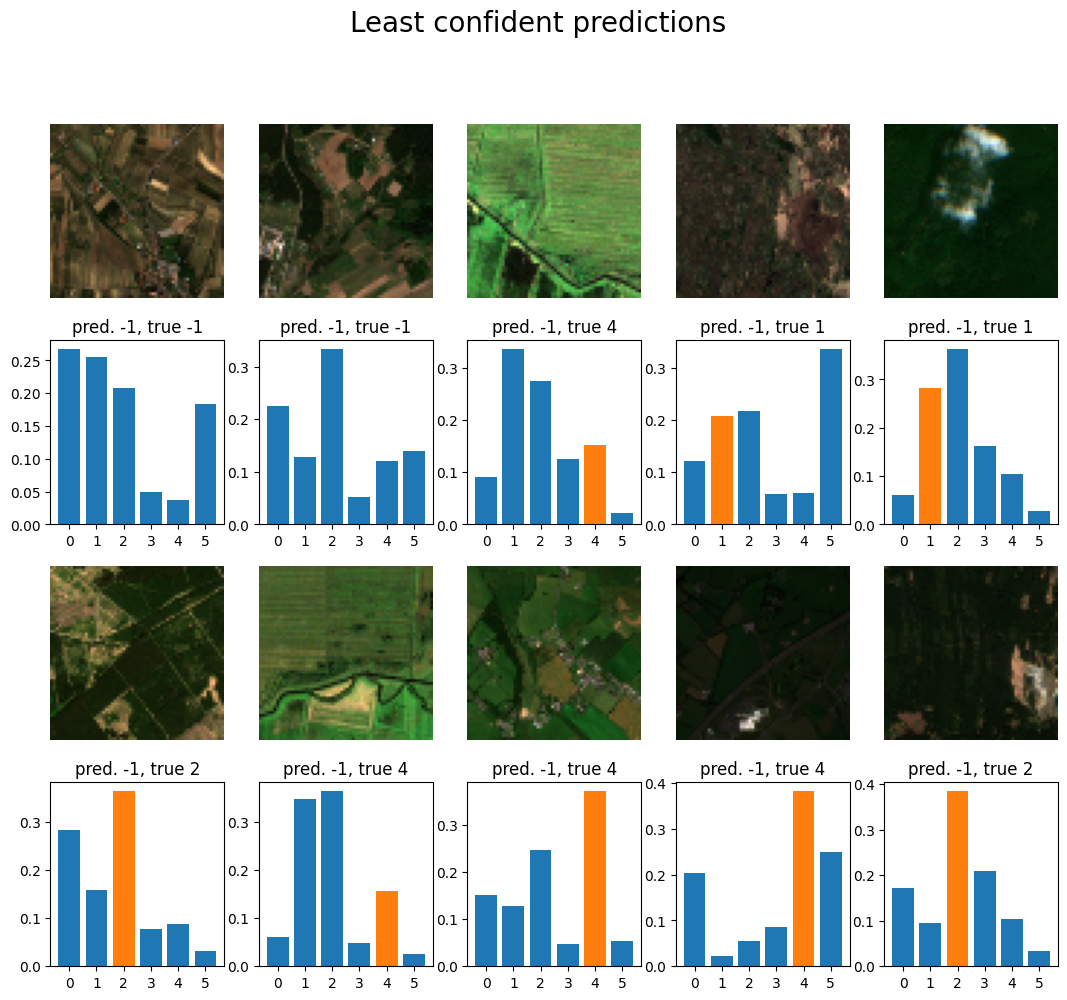

In [17]:
from importlib import reload
import model
import model_util
reload(model_util)
reload(model)
from model import SWAGInference
from model_util import InferenceType

def dataset_to_device(dataset, device):
    return torch.utils.data.TensorDataset(*[t.to(device) for t in dataset.tensors])

# Fix all randomness
setup_seeds()

# Build and run the actual solution
training_loader = torch.utils.data.DataLoader(
    dataset_to_device(training_dataset, 'mps'),
    batch_size=16,
    shuffle=True,
    num_workers=0,
)

swag_inference = SWAGInference(
    train_xs=training_dataset.tensors[0].to('mps'),
    model_dir=model_location,
    inference_mode=InferenceType.SWAG_FULL,
    device='mps',
    swag_training_epochs=30,
    swag_lr=4.5e-2,
    max_rank_deviation_matrix=15,
    num_bma_samples=30
)

swag_inference.fit(training_loader)
swag_inference.apply_calibration(validation_dataset)
with torch.random.fork_rng():
    evaluate(swag_inference, dataset_to_device(validation_dataset, 'mps'), True, output_location)


## Analyse parameter distribution

In [11]:
K = len(swag_inference.swag_deviations_deque)

# Instead of acting on a full vector of parameters, all operations can be done on per-layer parameters.
for name, param in swag_inference.network.named_parameters():
    # SWAG-diagonal part
    z_diag1 = torch.randn(param.size()).to(swag_inference.device)
    # TODO(1): Sample parameter values for SWAG-diagonal
    mean_weights = swag_inference.swag_mom1[name]
    var_weights = swag_inference.swag_mom2[name] - mean_weights**2
    # assert (var_weights >= 0).all()  # FIXME: WHY THE FUCK IS THIS NOT TRUE?
    std_weights = torch.sqrt(torch.clamp(var_weights, min=0))
    assert mean_weights.size() == param.size() and std_weights.size() == param.size()
    assert torch.isnan(mean_weights).sum() == 0 
    assert torch.isnan(std_weights).sum() == 0

    # Diagonal part
    sampled_weight = mean_weights + std_weights * z_diag1 * 1/np.sqrt(2)  # FIXME: Check const
    assert torch.isnan(sampled_weight).sum() == 0

    # Full SWAG part
    if swag_inference.inference_mode == InferenceType.SWAG_FULL:
        # TODO(2): Sample parameter values for full SWAG
        z_diag2 = torch.randn(K).to(swag_inference.device)
        Dhat = torch.stack([swag_inference.swag_deviations_deque[i][name] for i in range(K)], dim=-1)  # FIXME: Only do this once
        sampled_weight += torch.matmul(Dhat, z_diag2) * 1/np.sqrt(2*(K-1))

    # Modify weight value in-place; directly changing self.network
    # param.data = sampled_weight

In [51]:
var_weights.min(), var_weights.max()

(tensor(-1.7881e-07, device='mps:0'), tensor(3.5763e-07, device='mps:0'))

In [37]:
swag_inference.sample_parameters()

In [42]:
next(swag_inference.network.named_parameters())[1]

Parameter containing:
tensor([[[[        nan,         nan, -1.3349e-01,  9.7895e-04,         nan],
          [-1.3392e-01, -2.1615e-01, -9.6077e-02, -5.9490e-02, -1.0816e-02],
          [        nan,         nan, -1.7210e-01, -1.0401e-01, -5.4360e-03],
          [-3.7698e-01,         nan, -2.8657e-01,         nan,         nan],
          [-3.1472e-01, -4.4348e-01, -3.4251e-01, -2.2392e-01,         nan]],

         [[ 2.3735e-04,  8.1906e-02,  1.1716e-01,         nan,  1.1150e-01],
          [ 3.7722e-02,         nan,         nan,  3.3679e-02, -3.5068e-02],
          [        nan,  1.5107e-01,  1.2182e-01,  2.4558e-01,  6.1720e-02],
          [-5.3400e-02,         nan,  1.1867e-01,         nan,         nan],
          [        nan, -2.5275e-01, -8.5776e-02, -6.0151e-02,  1.2375e-02]],

         [[ 1.7533e-02,  6.8701e-02,  2.1612e-01,  1.5284e-01,         nan],
          [ 1.7710e-01,  1.2696e-01,  9.9059e-02,         nan,  2.6659e-01],
          [-6.7849e-02,         nan,  2.1314e-01, 

In [36]:
swag_inference.swag_mom2['layer0.0.weight'] - swag_inference.swag_mom1['layer0.0.weight']**2

tensor([[[[-4.6566e-10, -7.4506e-09,  1.8626e-09,  0.0000e+00, -1.1642e-10],
          [ 0.0000e+00,  0.0000e+00,  9.3132e-10,  0.0000e+00,  0.0000e+00],
          [-1.4901e-08, -7.4506e-09,  1.8626e-09,  1.8626e-09,  0.0000e+00],
          [ 1.4901e-08, -1.4901e-08,  7.4506e-09, -1.1642e-10, -5.8208e-11],
          [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  7.4506e-09, -4.6566e-10]],

         [[ 0.0000e+00,  4.6566e-10,  2.7940e-09, -4.6566e-10,  0.0000e+00],
          [ 2.3283e-10, -3.7253e-09, -3.7253e-09,  0.0000e+00,  1.1642e-10],
          [-2.7940e-09,  1.8626e-09,  9.3132e-10,  0.0000e+00,  2.3283e-10],
          [ 2.3283e-10, -1.8626e-09,  2.7940e-09, -9.3132e-10, -1.1642e-10],
          [-3.7253e-09,  0.0000e+00,  4.6566e-10,  0.0000e+00,  0.0000e+00]],

         [[ 2.9104e-11,  9.3132e-10,  3.7253e-09,  0.0000e+00, -1.4901e-08],
          [ 3.7253e-09,  1.8626e-09,  9.3132e-10, -2.9802e-08,  0.0000e+00],
          [ 0.0000e+00, -3.7253e-09,  0.0000e+00,  2.2352e-08,  0.0000e+

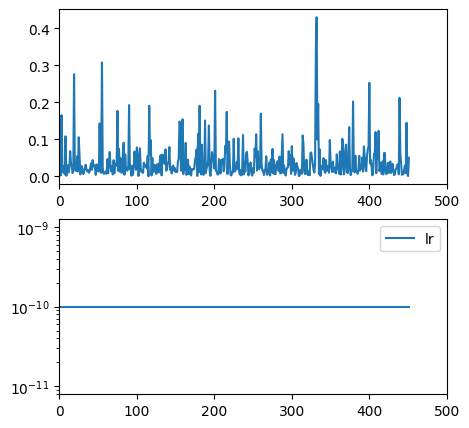

In [33]:
fig, [ax1, ax2] = plt.subplots(2, 1, figsize=(5, 5))

ax1.plot(swag_inference.history['loss-batch'], label='loss')
ax2.plot(swag_inference.history['lr'], label='lr')
ax1.set_xlim(0, 500)
ax2.set_xlim(0, 500)
ax2.set_yscale('log')
plt.legend()
plt.show()